In [1]:
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser, Select, PDBIO
from Bio.PDB.SASA import ShrakeRupley
import warnings
from Bio import BiopythonWarning
from src import EpitopeAnalyzer

### Pull surface exposed residues in heavy and light chain

In [ ]:


warnings.simplefilter("ignore", BiopythonWarning)

class SurfaceResidueSelector(Select):
    def __init__(self, threshold):
        self.threshold = threshold
        self.surface_residues = []

    def accept_residue(self, residue):
        if hasattr(residue, "sasa") and residue.sasa > self.threshold:
            self.surface_residues.append(residue)
            return True
        return False

def find_surface_residues_without_chain(pdb_file, exclude_chain_id="A", sasa_threshold=50.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]

    if exclude_chain_id in model:
        model.detach_child(exclude_chain_id)

    sr = ShrakeRupley(n_points=1000)
    sr.compute(model, level='R')

    selector = SurfaceResidueSelector(sasa_threshold)
    io = PDBIO()
    io.set_structure(model)
    io.save("surface_residues_no_chainA.pdb", selector)

    return selector.surface_residues

pdb_path = "./out/antibody_output/seq_evolve_norm24/spp1_rabd_SPP1_antobody_bound_0079.pdb"
surface_residues = find_surface_residues_without_chain(pdb_path, exclude_chain_id="A", sasa_threshold=50.0)

store_surface_res = {"H": [], "L": []}
for residue in surface_residues:
    chain_id = residue.get_parent().id
    resname = residue.get_resname()
    resid = residue.get_id()[1]
    store_surface_res[chain_id].append(resid)



## Heavy chain class I hits

In [7]:
ETOP = EpitopeAnalyzer(surface_res=store_surface_res)
ETOP.download_allele_frequency_file(url="https://ars.els-cdn.com/content/image/1-s2.0-S0198885913001821-mmc5.xls",filename="1-s2.0-S0198885913001821-mmc5.xls")

File downloaded to: ./in/epitope/1-s2.0-S0198885913001821-mmc5.xls


'./in/epitope/1-s2.0-S0198885913001821-mmc5.xls'

In [8]:
df_ABC= ETOP.load_and_prepare_frequency_table("./in/epitope/1-s2.0-S0198885913001821-mmc5.xls", select_class=("HLA-A", "HLA-B", "HLA-C"))
heavy_chain_hits = ETOP.load_heavy_chain_hits(filepath="./in/epitope/tepitool_heavy_chain_classI_hits.csv")
heavy_chain_filtered = ETOP.filter_epitope_hits(ic50_cutoff=150)
heavy_chain_SA = ETOP.calculate_surface_exposure(heavy_chain_filtered, chain="H")
heavy_chain_SA

Seq #  Peptide start  Peptide end    Peptide   IC50       Allele   
11      1            172          180  VLQSDLYTL  33.82  HLA-A*02:01  \
31      1             80           88  MLYLQMNNL  91.43  HLA-A*02:01   
33      1            137          145  SMVTLGCLV  94.00  HLA-A*02:01   
36      1            178          186  YTLSSSVTV  97.30  HLA-A*02:01   

    % Surface Exposed  
11          55.555556  
31          33.333333  
33          22.222222  
36           0.000000

In [9]:
output_excel_path = "./out/antibody_epitope/heavy_chain_surface_epitopes.xlsx"
heavy_chain_SA.to_excel(output_excel_path, index=False)
print(f"Final epitope table saved to: {output_excel_path}")

Final epitope table saved to: ./out/antibody_epitope/heavy_chain_surface_epitopes.xlsx


## Light chain class I

In [10]:
df_ABC_L1= ETOP.load_and_prepare_frequency_table("./in/epitope/1-s2.0-S0198885913001821-mmc5.xls", select_class=("HLA-A", "HLA-B", "HLA-C"))
light_chain_hits = ETOP.load_heavy_chain_hits(filepath="./in/epitope/tepitool_light_chain_classI_hits.csv")
light_chain_filtered = ETOP.filter_epitope_hits(ic50_cutoff=150)
light_chain_SA = ETOP.calculate_surface_exposure(light_chain_filtered, chain="L")
light_chain_SA

Seq #  Peptide start  Peptide end    Peptide    IC50       Allele   
31      1             90           98  HFWGTPFTF  114.45  HLA-A*24:02  \

    % Surface Exposed  
31          22.222222

## Heavy chain class II

In [11]:
heavy_chain_classII = ETOP.read_classII_table("./in/epitope/tepitool_heavy_chain_classII_hits.csv")
heavy_chain_classII

Seq #  Peptide start  Peptide end          Peptide  Median percentile rank
0      1             56           70  NNYTTYYADSVKDRF                     5.1
1      1             66           80  VKDRFTISRDDSQSM                     9.2

In [12]:
heavy_chain_classII_SA = ETOP.calculate_surface_exposure(heavy_chain_classII, chain="H")
heavy_chain_classII_SA

Seq #  Peptide start  Peptide end          Peptide  Median percentile rank   
0      1             56           70  NNYTTYYADSVKDRF                     5.1  \
1      1             66           80  VKDRFTISRDDSQSM                     9.2   

   % Surface Exposed  
0          60.000000  
1          33.333333

## Light chain class II

In [13]:
light_chain_classII = ETOP.read_classII_table("./in/epitope/tepitool_light_chain_classII_hits.csv")
light_chain_classII

Seq #  Peptide start  Peptide end          Peptide  Median percentile rank
0      1            101          115  GTKLEIKRSDAAPTV                     4.6
1      1            146          160  VKWKIDGAERGNGVL                     6.8

In [14]:
light_chain_classII_SA = ETOP.calculate_surface_exposure(light_chain_classII, chain="L")
light_chain_classII_SA

Seq #  Peptide start  Peptide end          Peptide  Median percentile rank   
1      1            146          160  VKWKIDGAERGNGVL                     6.8  \
0      1            101          115  GTKLEIKRSDAAPTV                     4.6   

   % Surface Exposed  
1               60.0  
0               40.0

## Lets find human antibody matching to out evolved AB

### 1. Heavy chain sequence alignment

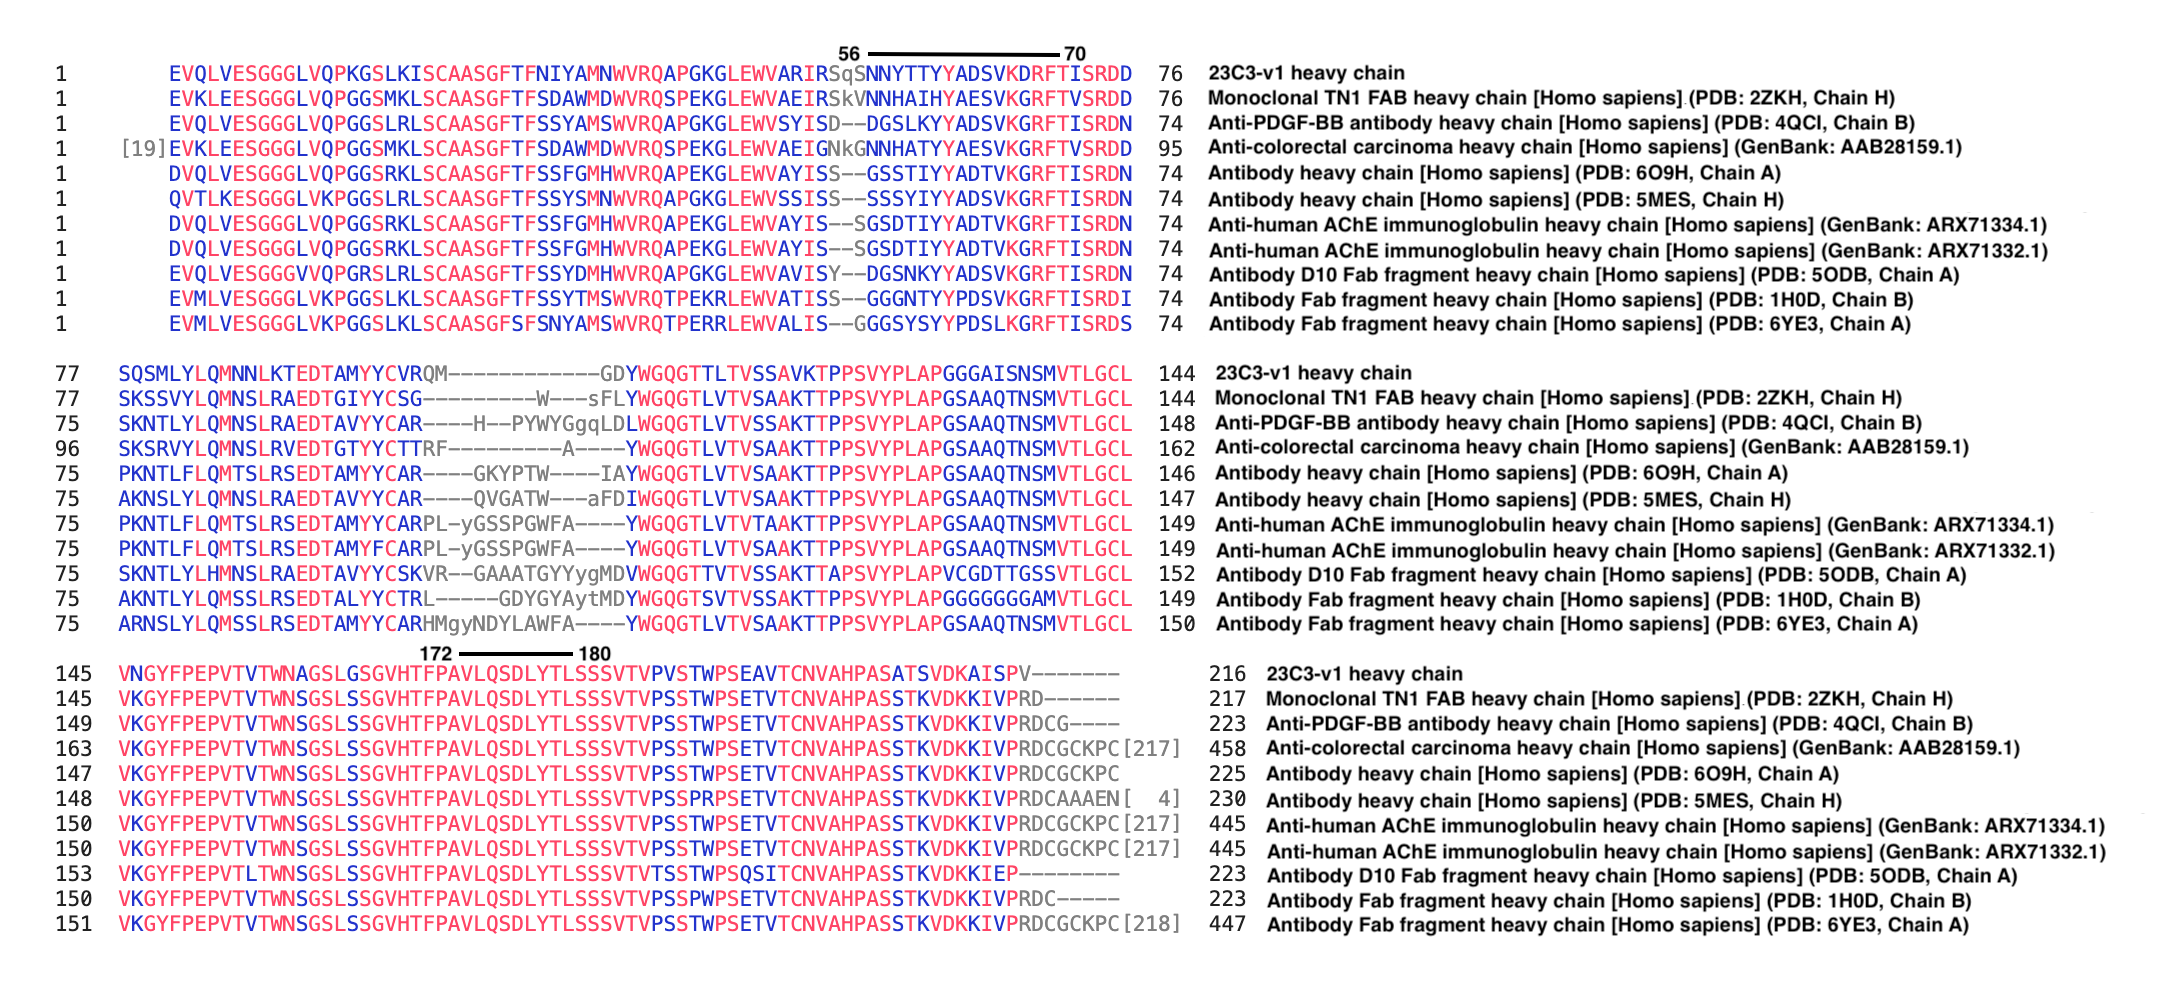

In [15]:
from IPython.display import Image, display

display(Image(filename="./out/antibody_epitope/heavy_chain_alignment.png"))


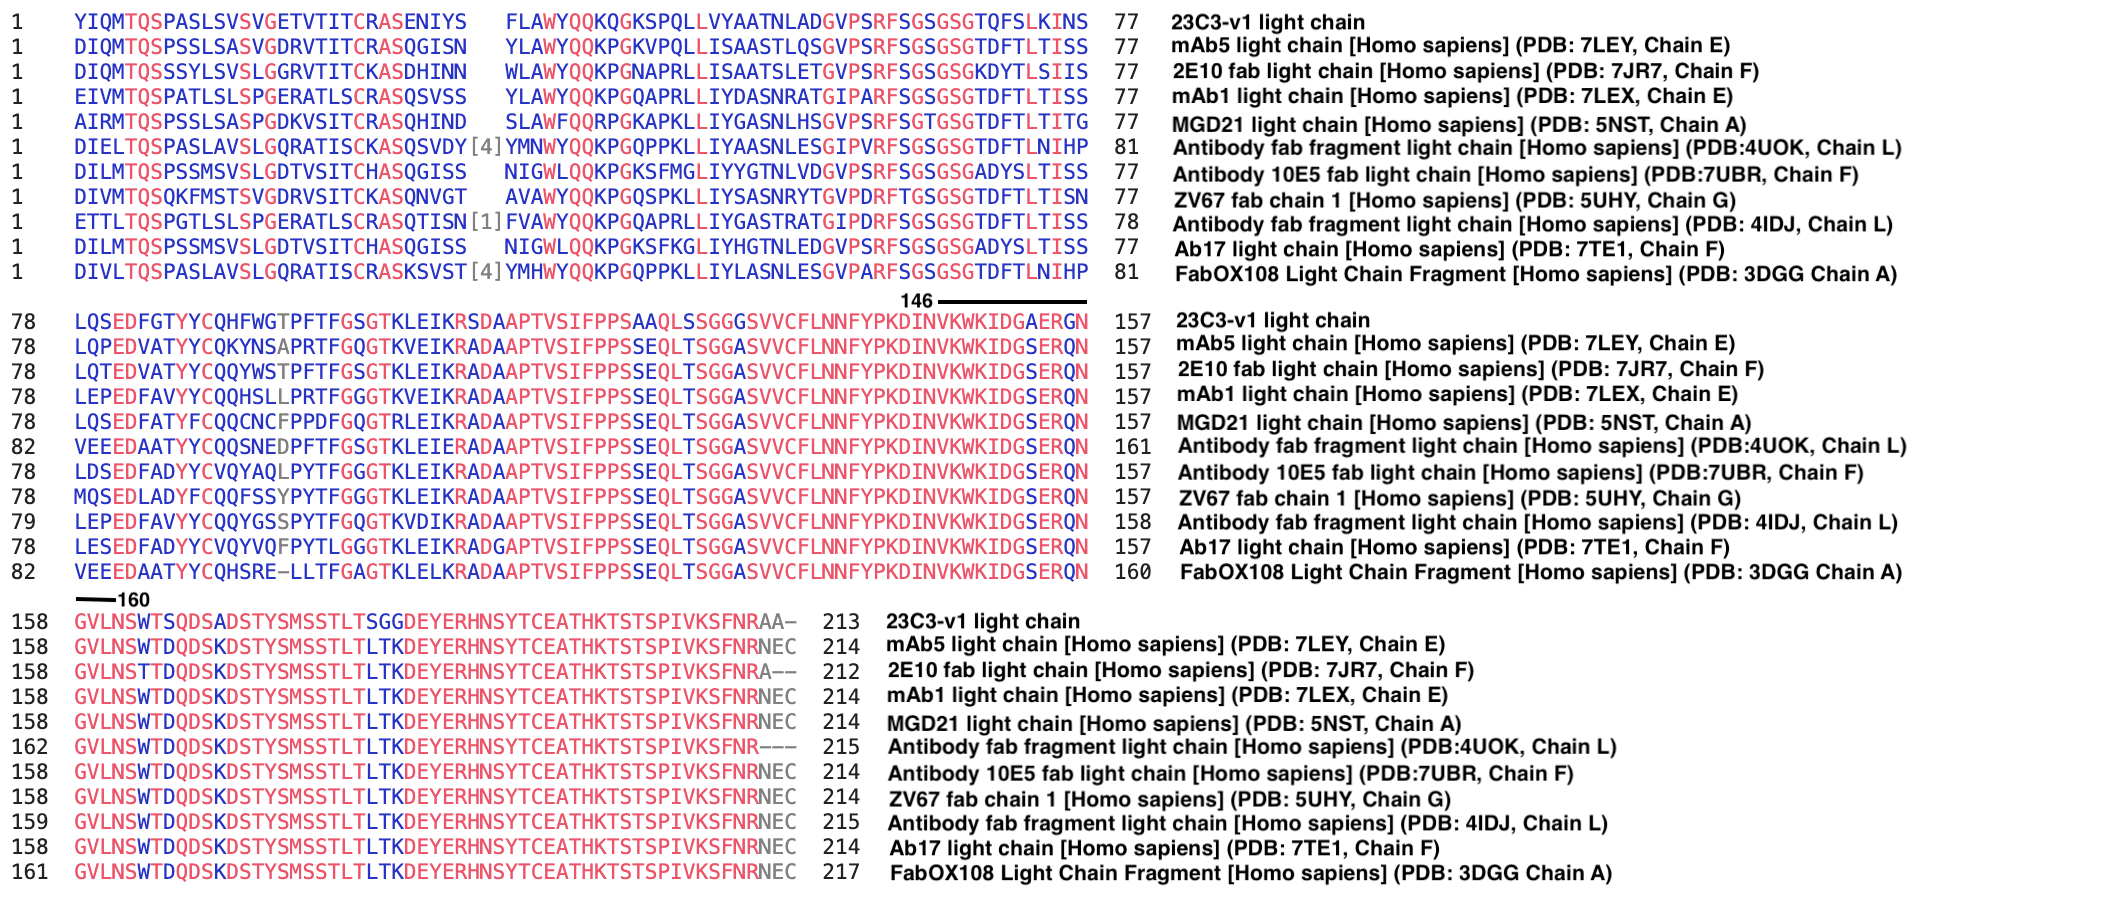

In [16]:
display(Image(filename="./out/antibody_epitope/light_chain_alignment.png"))

# Humanizing 23C3-v1
### Lets look at these regions across multiple human antibody heavy and light chains

Observations
1. Heavy chain
   - a) Residue 61-70 is highly conserved across all human antibodies. 
   - b) Residue 56-62 contains all hydrophilic polar residues (Asparagine, Tyrosine, and Threonine).
   - c) My first thought is to change these hydrophilic polar residues in 56-62 to hydrophobic non-polar in order to loose CD4 binding, while retaining SPP1 binding. 
   - d) Tyrosine (Y) can be modified to Tryptophan (F) (Hydrophobic non-polar) to loose polar -OH group but retain aromatic structure.
   - e) Asparagine (N) can be be modified to Leucine (Hydrophobic non-polar)

Sequence NNYTTYYADSVKDRF was modified to LLWTTWWADSVKDRF (23C3-v2), which did help remove class II epitope hits as shown below. 

In [18]:
heavy_chain_classII = ETOP.read_classII_table("./in/epitope/tepitool_heavy_chain_classII_56-70_epitope_neuralized.csv")
heavy_chain_classII

Seq #  Peptide start  Peptide end          Peptide  Median percentile rank
0      1             66           80  VKDRFTISRDDSQSM                     9.2

### Residue 172-180
Its highly conserved across all top 10 human epitope blast hit, indicating functional significance. Ideally, with the availablity of Immunoprecipitation followed by Western blotting, it would be ideal to explore directed evolution in this region.   

### Light chain 146-160
Here we can back mutate A152 to S and G155 to Q

### Final list of mutations
- #### Heavy chain mutations (Red spheres)
   - N56L
   - N57L
   - Y58W
   - Y61W
   - Y62W
- #### Light chain mutations (blue spheres)
   - A153S
   - G156Q

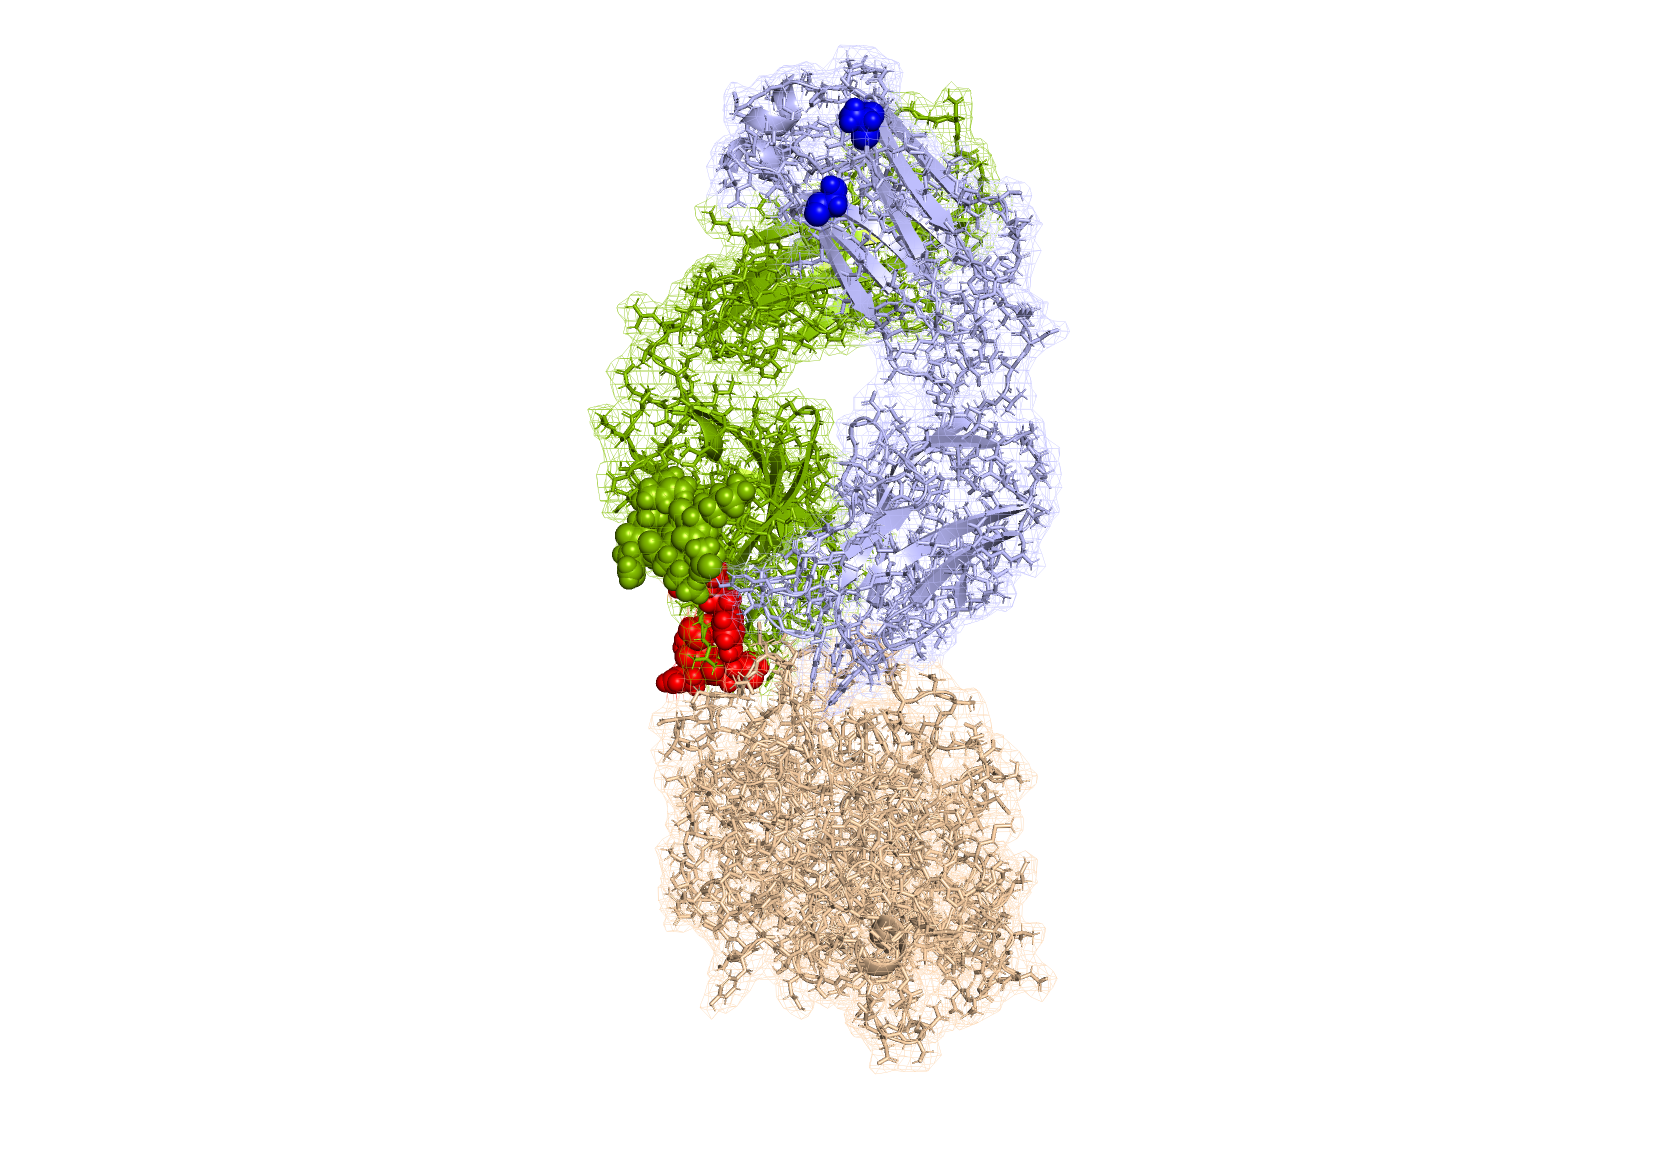

In [7]:
display(Image(filename="./out/antibody_epitope/humanization_mutations.png"))

## MD Simulation
- Now the question, how bad are these modifications on H2 binding to SPP1. Let apply Molecular dynamics (MD) simulation on SPP1 bonded 23C3-v1 and SPP1 bonded 23C3-v2. 
- And while we are at it, lets run MD simulation on pSer169 SPP1 bonded 23C3-v1 and  pSer169 SPP1 23C3-v2.

#### Quadratic mean of heavy chain RMSF across all three MD simulation trajectory replicates
- Black 23C3-v1
- Red Hu23C3-v1

Slight increase in fluctuation in Hu23C3-v1 was observed in region 62-68, which is distant from SPP1 binding interface

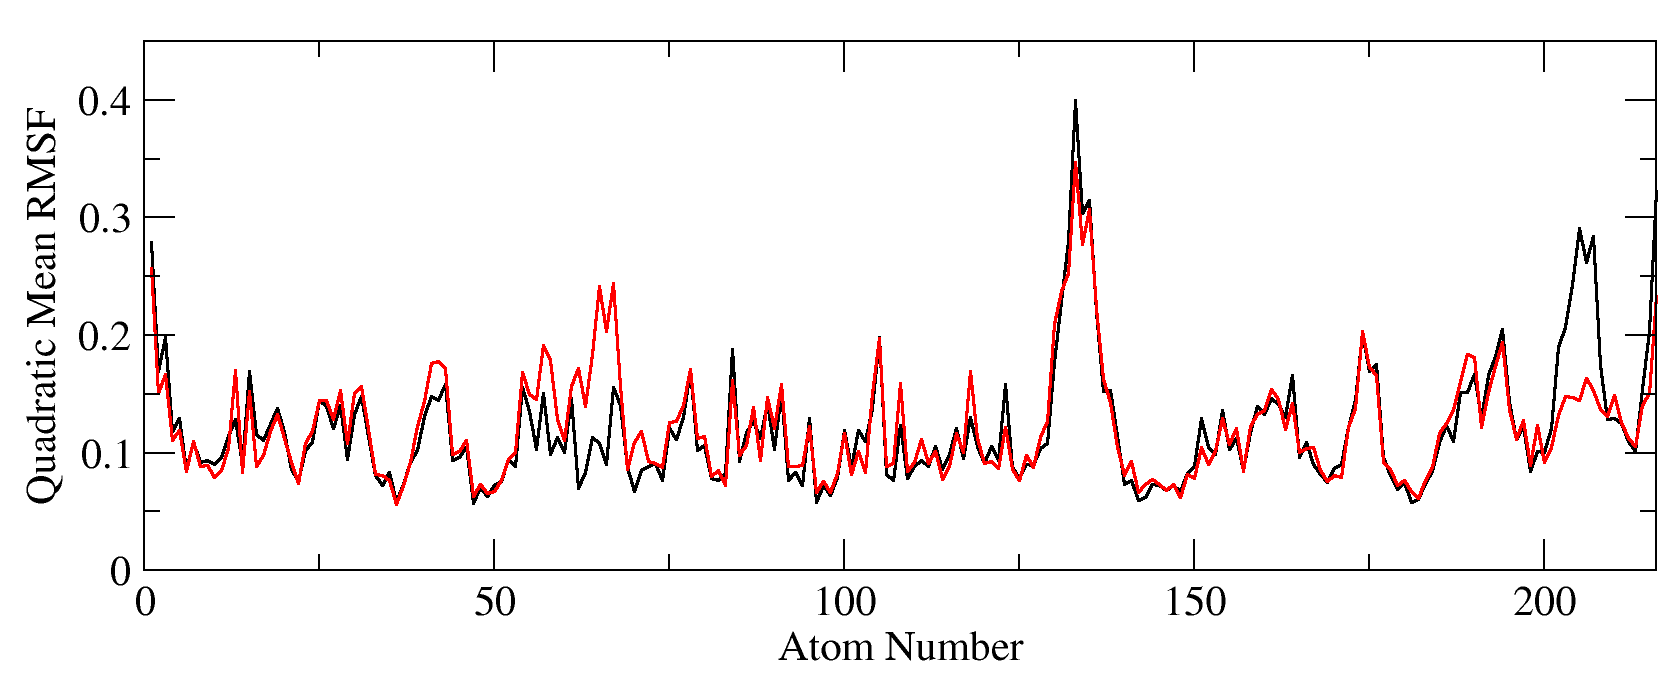

In [3]:
from IPython.display import Image, display
display(Image(filename="../Step12_Antibody_Molecular_Dynamics/out/images/quad_rmsf_heavy.png"))

#### Quadratic mean of light chain RMSF across all three MD simulation trajectory replicates
- Black 23C3-v1
- Red Hu23C3-v1

No change in fluctuation in light chain was observed

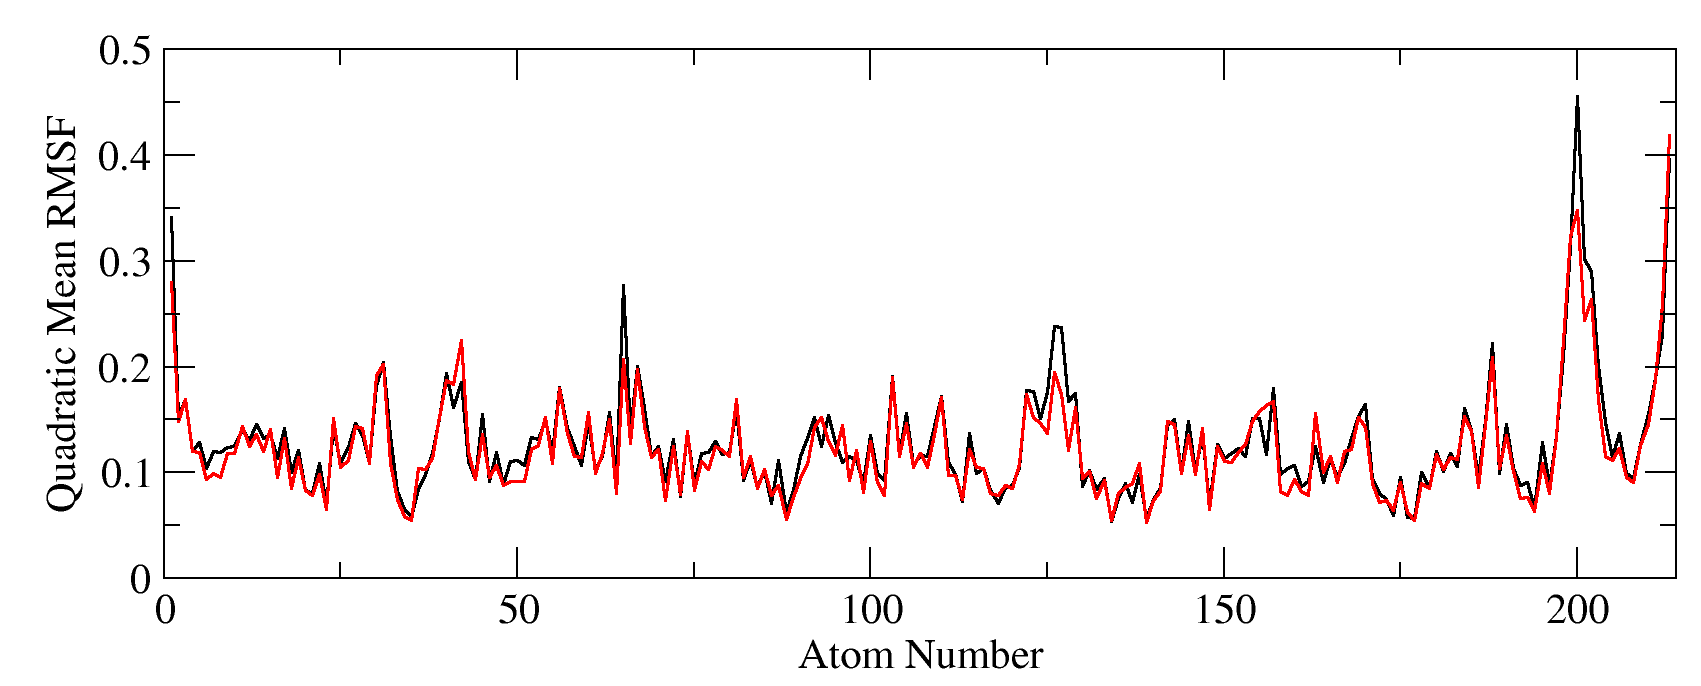

In [5]:
display(Image(filename="../Step12_Antibody_Molecular_Dynamics/out/images/quad_rmsf_light.png"))

### Binding affinity change
- No significant difference in binding affinity was observed in Hu23C3-v1 as compared to 23C3-v1

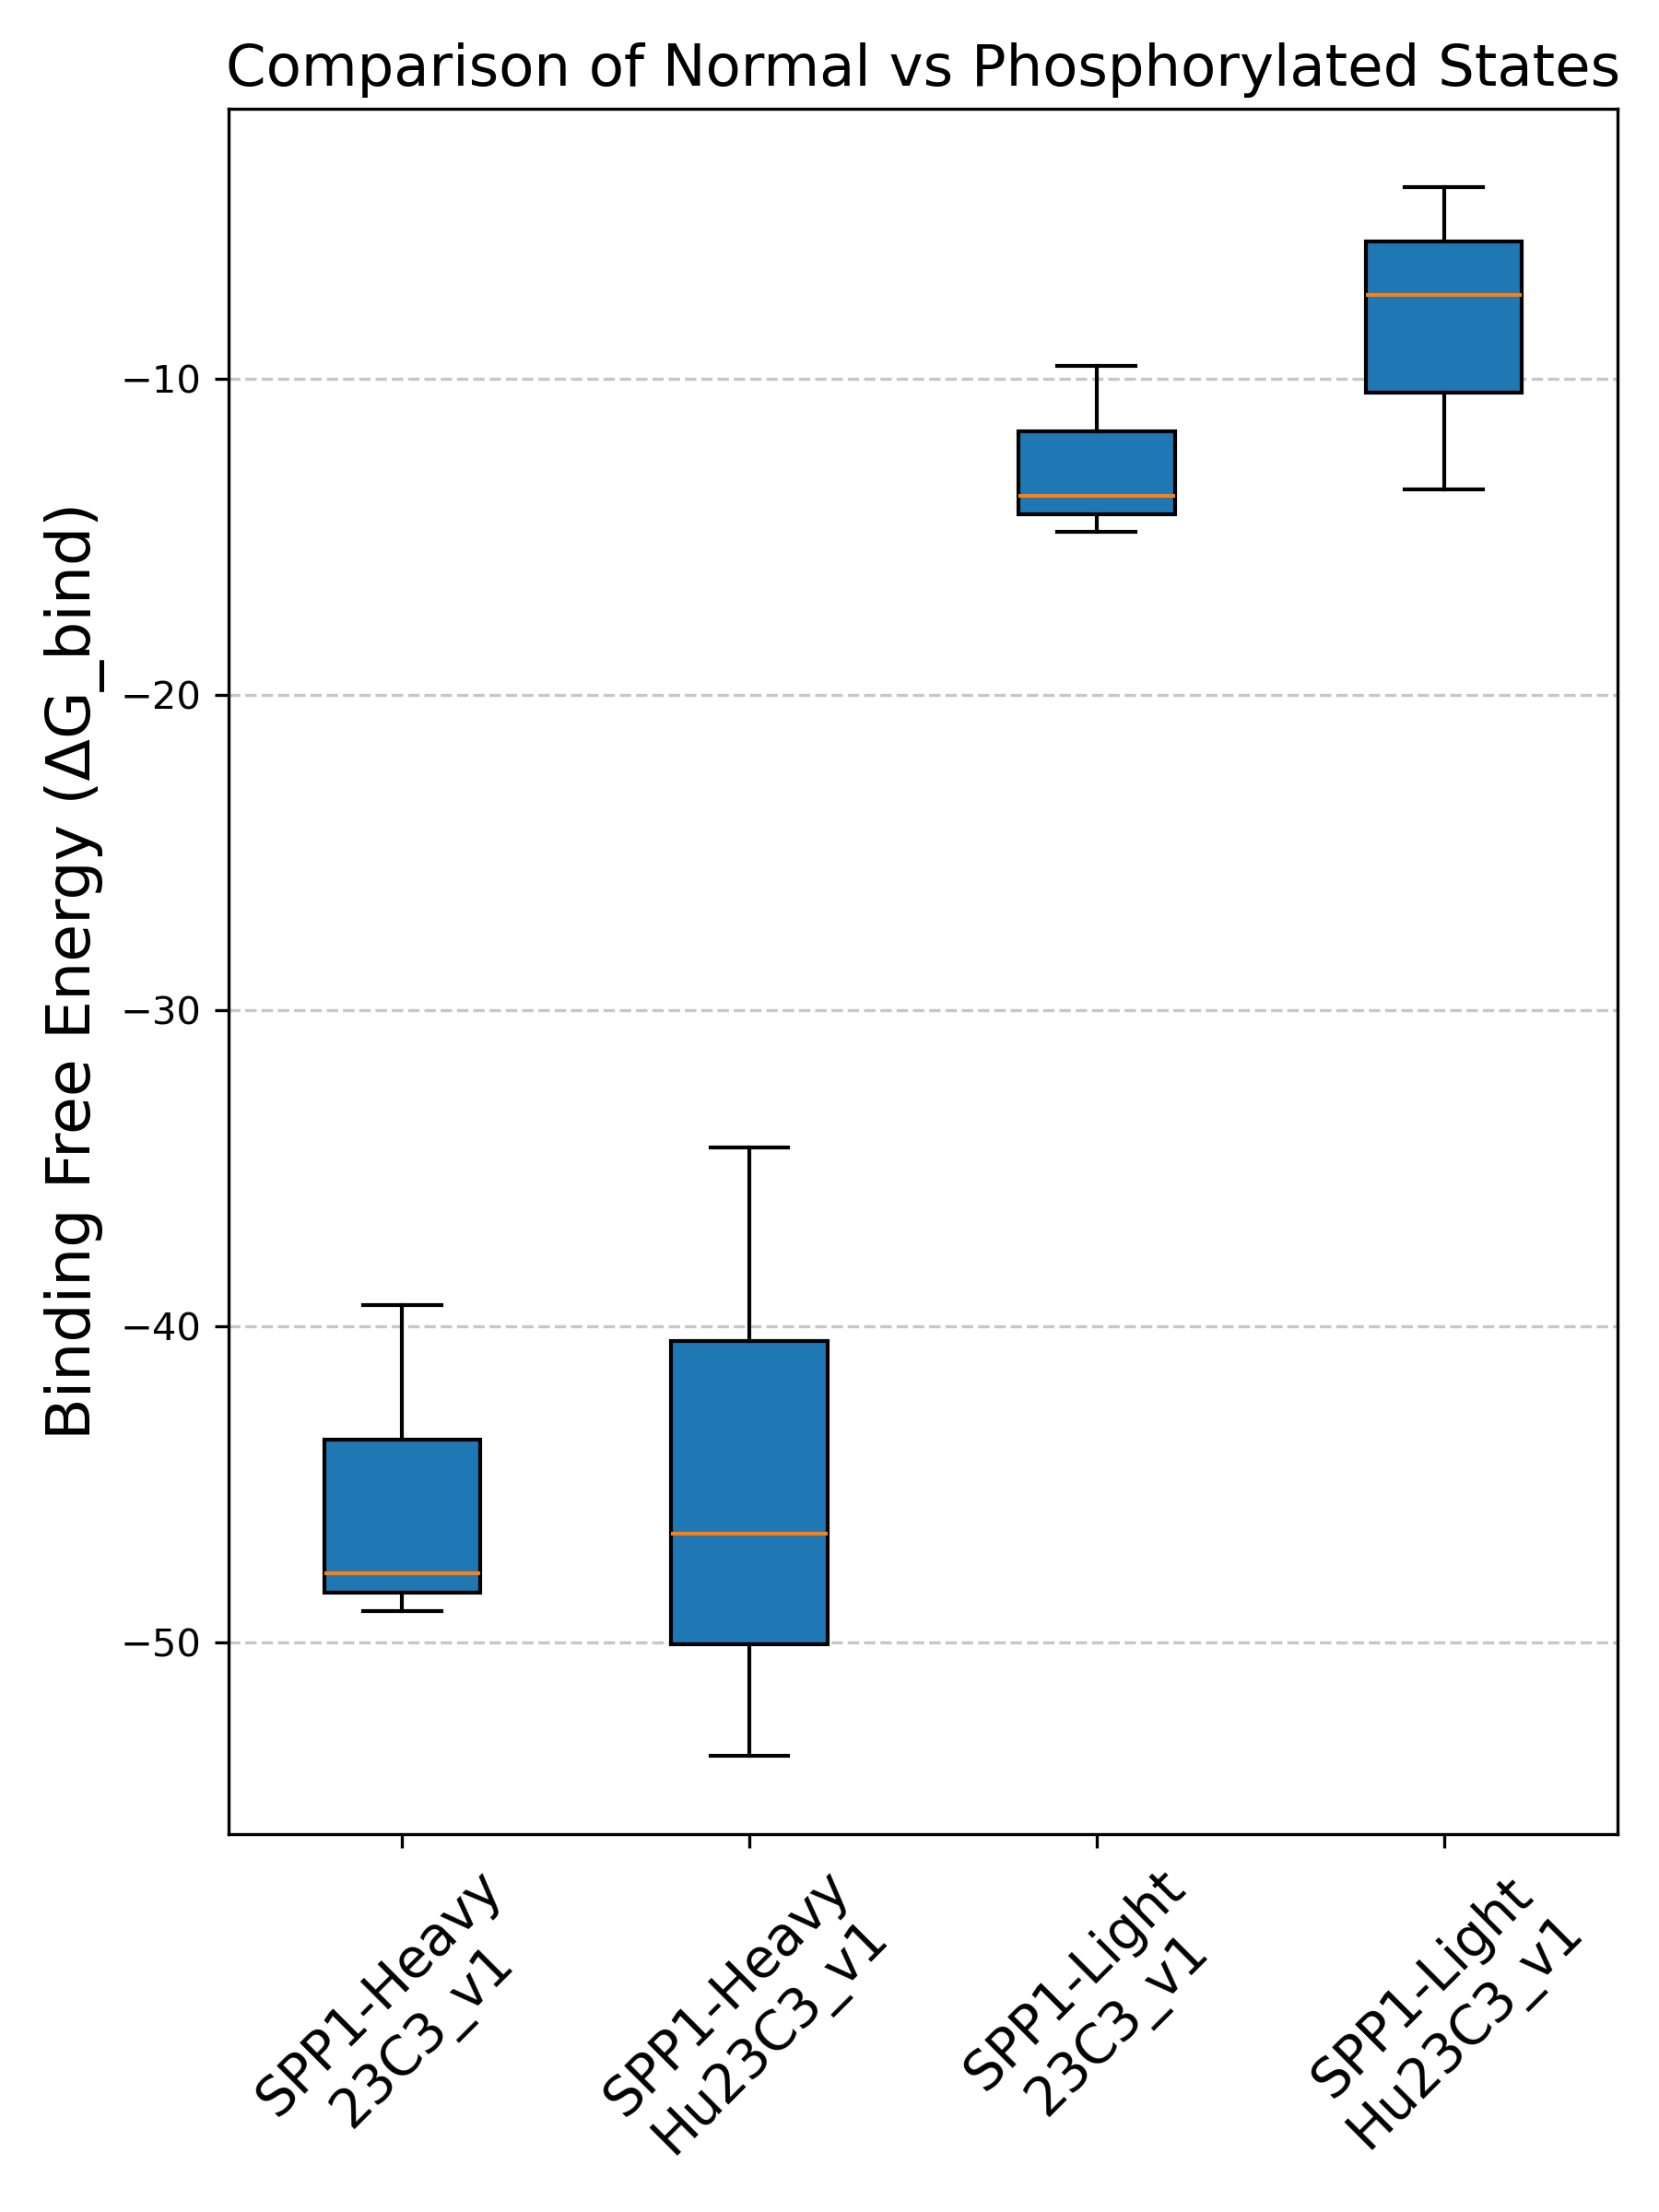

In [9]:
display(Image(filename="../Step13_Binding_Affinity_MMPBSA/out/boxplot_binding_energy.png"))

### Conclusion
- Mutations induced in 23C3-v1 humanization step did not significantly alter antibody conformational dynamics and its binding affinity to SPP1. 